In [99]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
plt.style.use('seaborn')
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [102]:
df=pd.read_csv('train_values.csv')
la=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_values.csv')
df['damage_grade']=la['damage_grade']
print("shape of train data set :", chr(128523),df.shape)
print('shape of test data set :', chr(128518),test.shape)
df.head()

shape of train data set : 😋 (260601, 40)
shape of test data set : 😆 (86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [4]:
df.describe().T.style.background_gradient(cmap='Set3')

,count,mean,std,min,25%,50%,75%,max
building_id,260601.000000,525675.482773,304544.999032,4.000000,261190.000000,525757.000000,789762.000000,1052934.000000
geo_level_1_id,260601.000000,13.900353,8.033617,0.000000,7.000000,12.000000,21.000000,30.000000
geo_level_2_id,260601.000000,701.074685,412.710734,0.000000,350.000000,702.000000,1050.000000,1427.000000
geo_level_3_id,260601.000000,6257.876148,3646.369645,0.000000,3073.000000,6270.000000,9412.000000,12567.000000
count_floors_pre_eq,260601.000000,2.129723,0.727665,1.000000,2.000000,2.000000,2.000000,9.000000
age,260601.000000,26.535029,73.565937,0.000000,10.000000,15.000000,30.000000,995.000000
area_percentage,260601.000000,8.018051,4.392231,1.000000,5.000000,7.000000,9.000000,100.000000
height_percentage,260601.000000,5.434365,1.918418,2.000000,4.000000,5.000000,6.000000,32.000000
has_superstructure_adobe_mud,260601.000000,0.088645,0.284231,0.000000,0.000000,0.000000,0.000000,1.000000
has_superstructure_mud_mortar_stone,260601.000000,0.761935,0.425900,0.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.describe(include="object").T

,count,unique,top,freq
land_surface_condition,260601,3,t,216757
foundation_type,260601,5,r,219196
roof_type,260601,3,n,182842
ground_floor_type,260601,5,f,209619
other_floor_type,260601,4,q,165282
position,260601,4,s,202090
plan_configuration,260601,10,d,250072
legal_ownership_status,260601,4,v,250939


In [6]:
dtype=pd.DataFrame(df.dtypes,columns=['dtypes'])
dtype['unique_values']=df.nunique()
dtype['null_values']=df.isnull().sum()
dtype.style.background_gradient(cmap='Set3',axis=1)


,dtypes,unique_values,null_values
building_id,int64,260601,0
geo_level_1_id,int64,31,0
geo_level_2_id,int64,1414,0
geo_level_3_id,int64,11595,0
count_floors_pre_eq,int64,9,0
age,int64,42,0
area_percentage,int64,84,0
height_percentage,int64,27,0
land_surface_condition,object,3,0
foundation_type,object,5,0


In [7]:
# checking if some features taking after the earth quake
[col for col in df.columns if 'post_eq' in col]


[]

<Axes: >

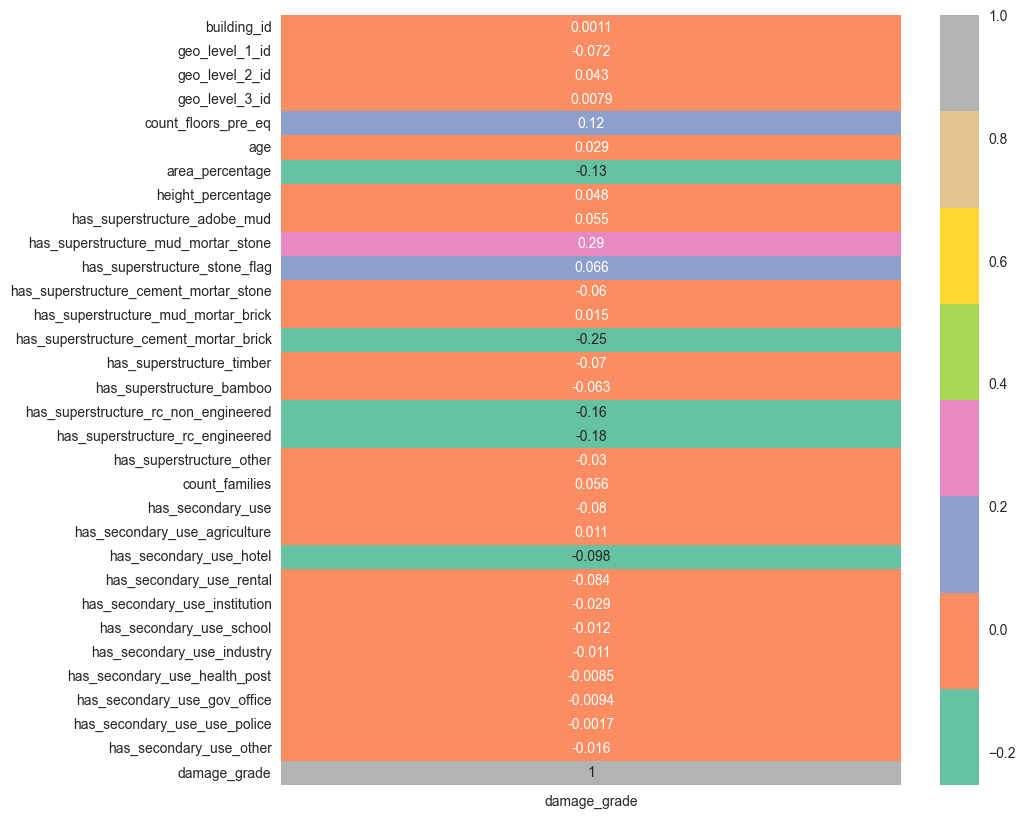

In [8]:
#check multi colinearity with damage grade column
dff=df.select_dtypes(exclude='object')
plt.figure(figsize=(10,10))
cor=dff.corr()["damage_grade"]
cor=pd.DataFrame(cor)
sns.heatmap(cor,annot=True,cmap="Set2")

<Axes: >

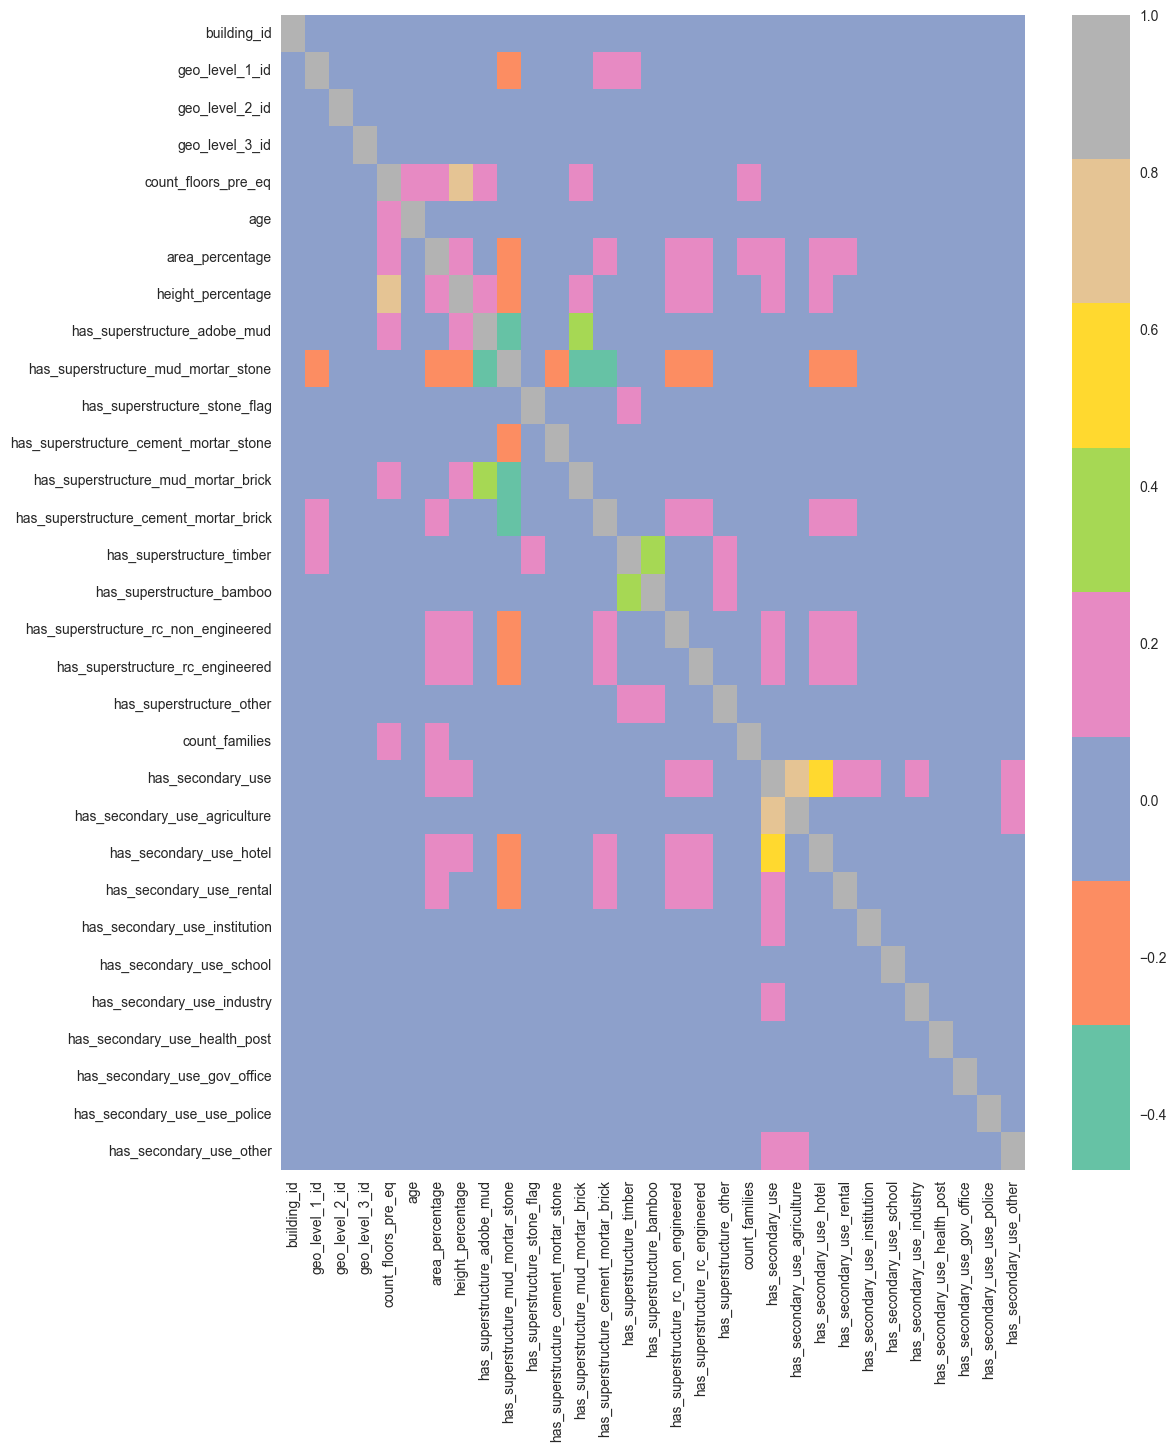

In [9]:
#check multi colinearity 
plt.figure(figsize=(12,15))
corr=df.select_dtypes('number').drop(columns='damage_grade').corr()
sns.heatmap(corr,cmap='Set2')

In [10]:
#droping multicolinear columns
drop_col=['building_id','count_floors_pre_eq','has_secondary_use','has_superstructure_bamboo','has_superstructure_adobe_mud']
df.drop(columns=drop_col,inplace=True)

<Axes: >

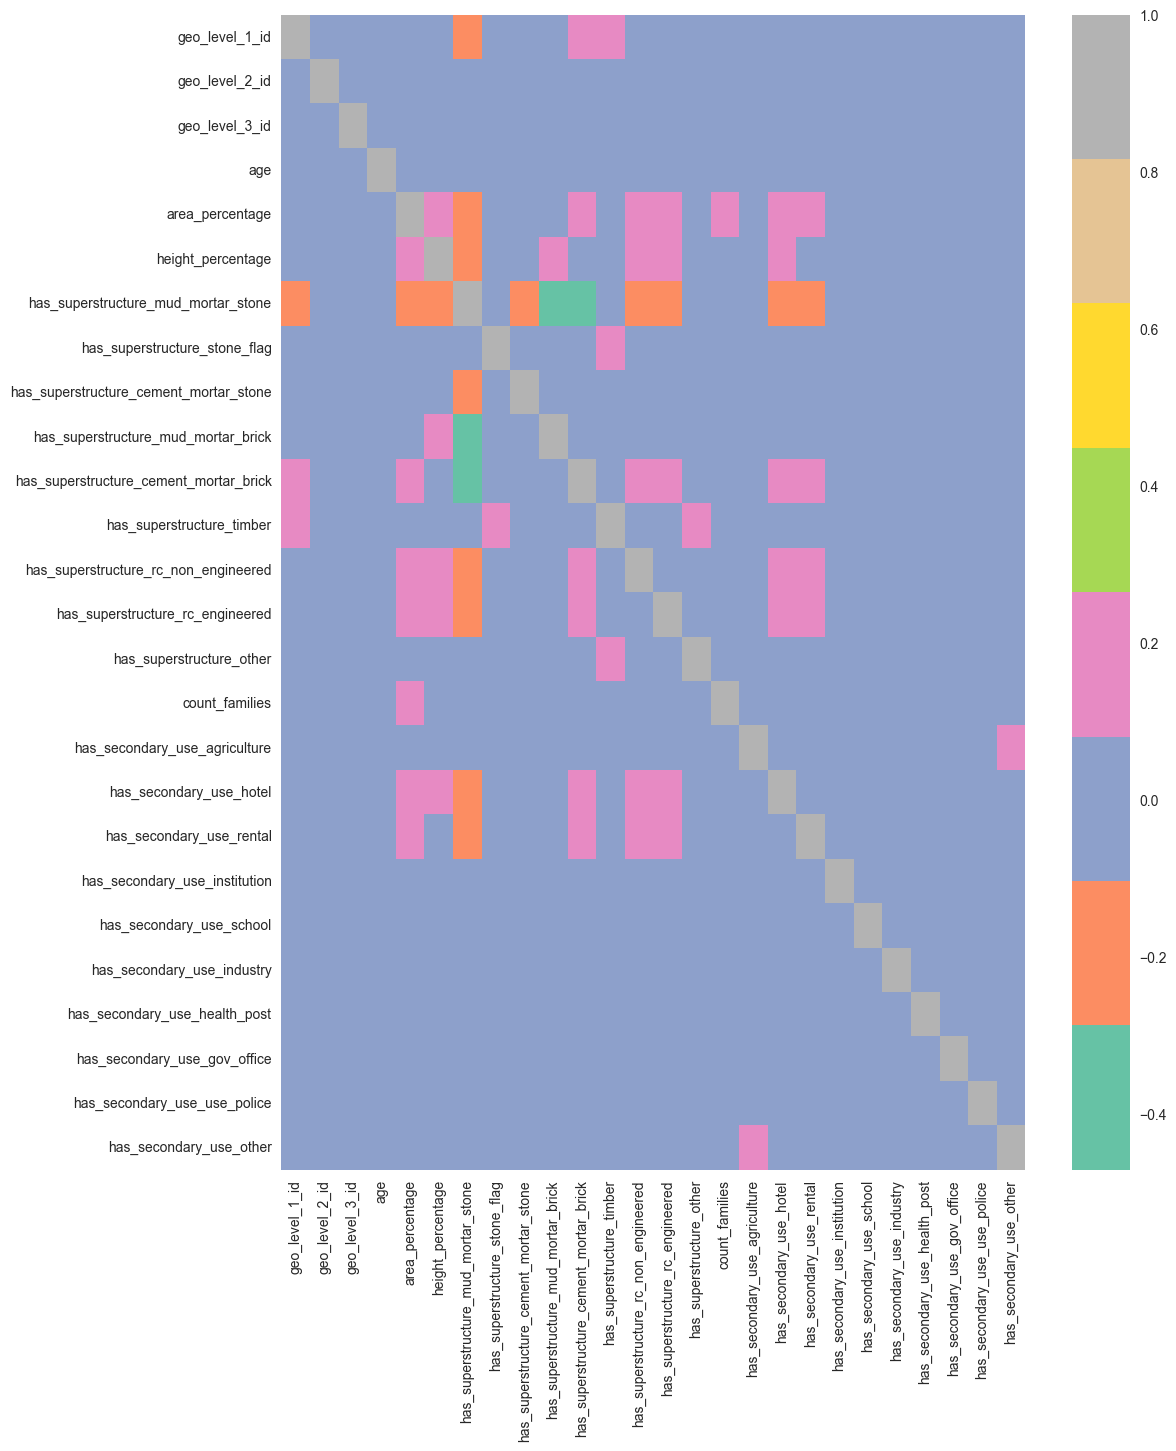

In [11]:
#correlation after droping multicolinear columns
plt.figure(figsize=(12,15))
corr=df.select_dtypes('number').drop(columns='damage_grade').corr()
sns.heatmap(corr,cmap='Set2')

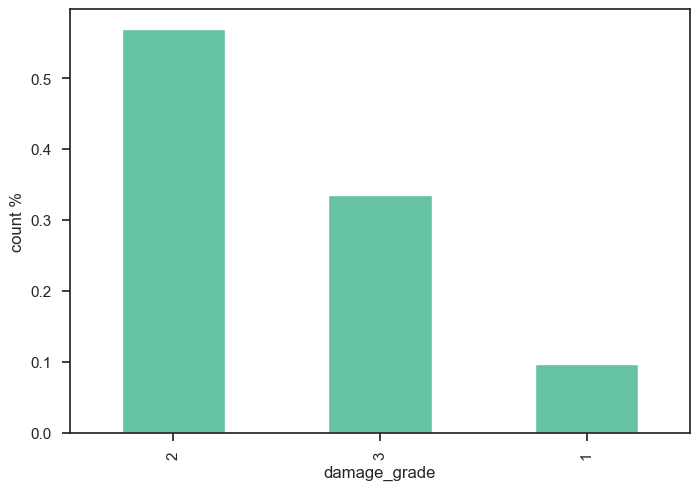

In [12]:
sns.set(style="ticks")
df['damage_grade'].value_counts(normalize=True).plot(kind='bar', cmap="Set2")
plt.xlabel('damage_grade')
plt.ylabel('count %')
plt.show()

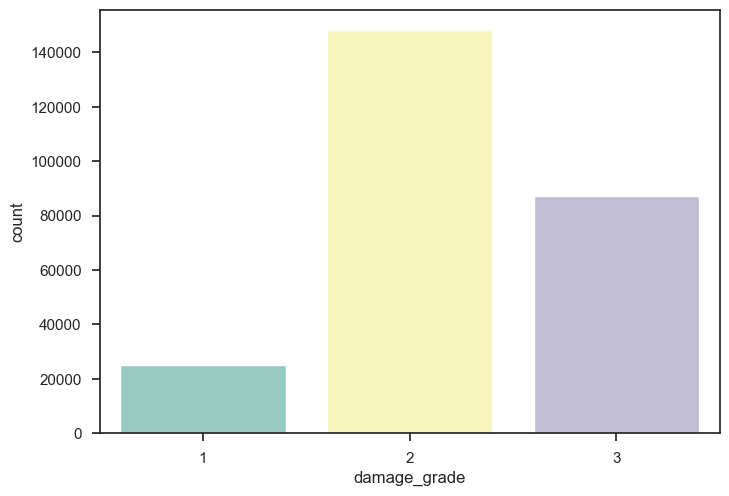

In [13]:
sns.set(style="ticks") 
# Plot the count plot
sns.countplot(x=df['damage_grade'], palette="Set3")  
plt.show();

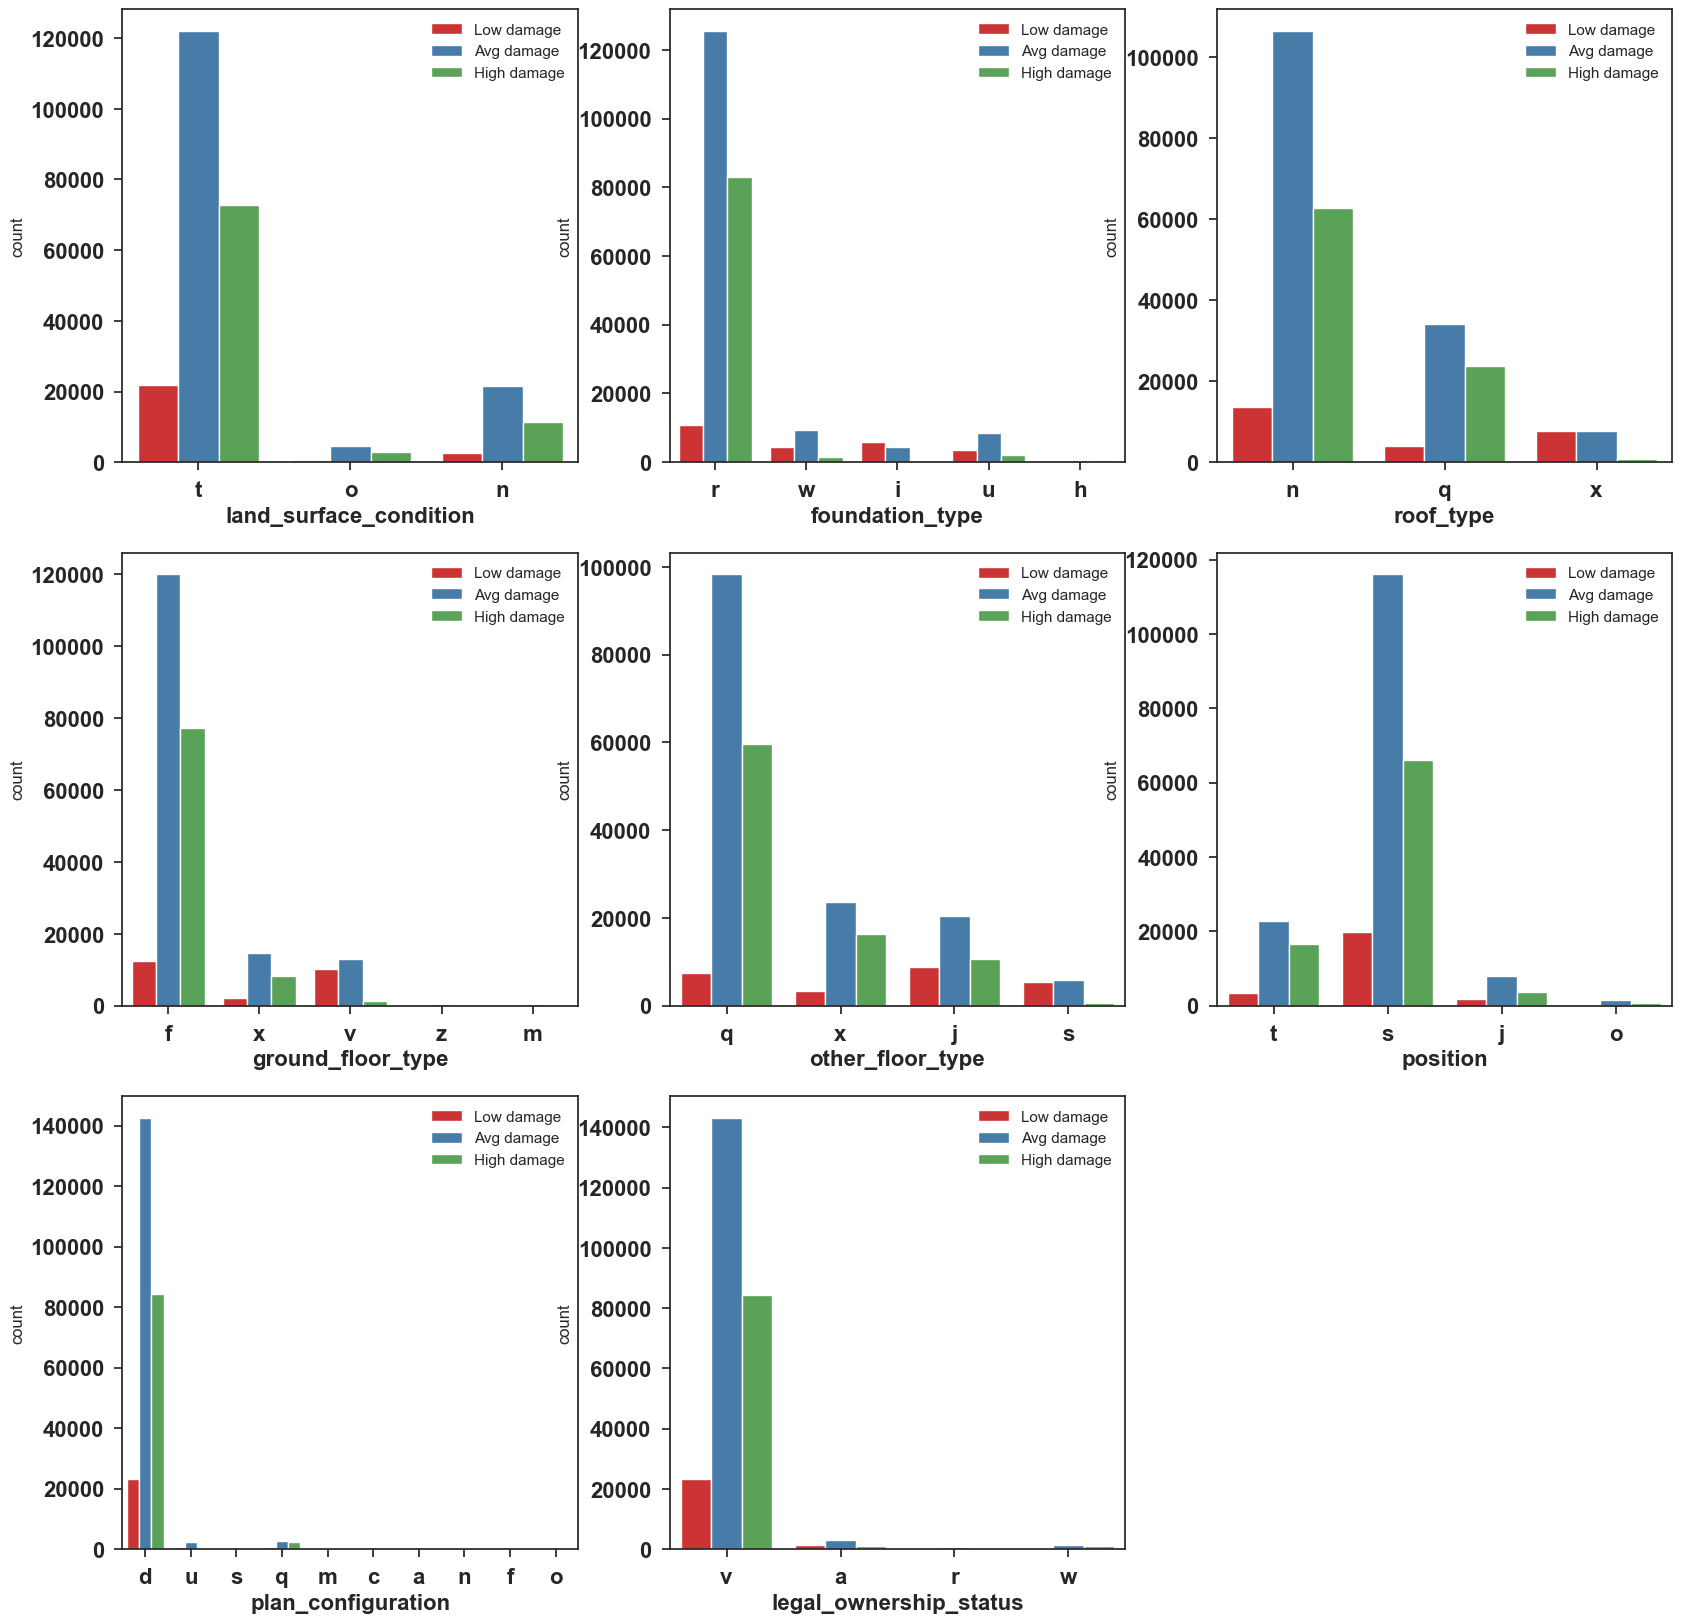

In [14]:
cat_columns=df.select_dtypes(include="object")    
font={'weight' : 'bold','size': 16}   
q=1
plt.figure(figsize=(20,20))
for x in cat_columns:
    plt.subplot(3,3,q)
    ax=sns.countplot(x=df[x].dropna(),palette="Set1",hue=df["damage_grade"])
    plt.xticks(**font)
    plt.yticks(**font)
    plt.xlabel(x,font={'weight' : 'bold','size': 16})
    plt.legend(["Low damage","Avg damage","High damage"])
    q+=1
plt.show()

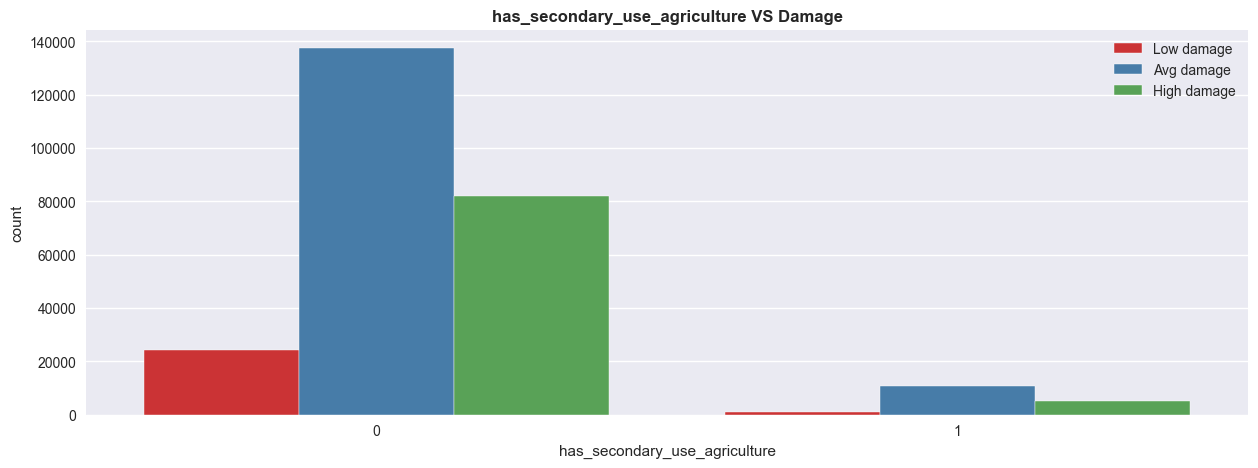

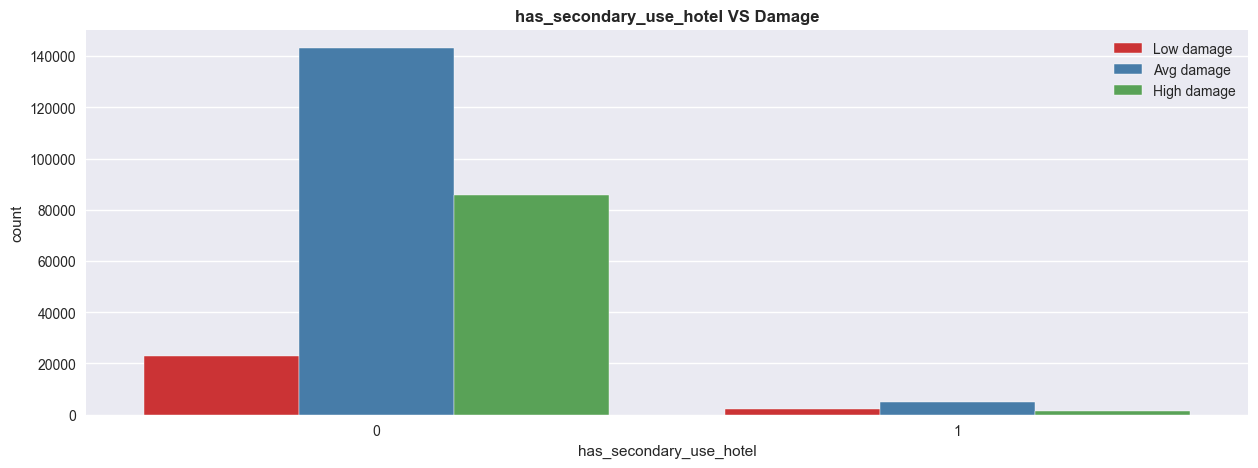

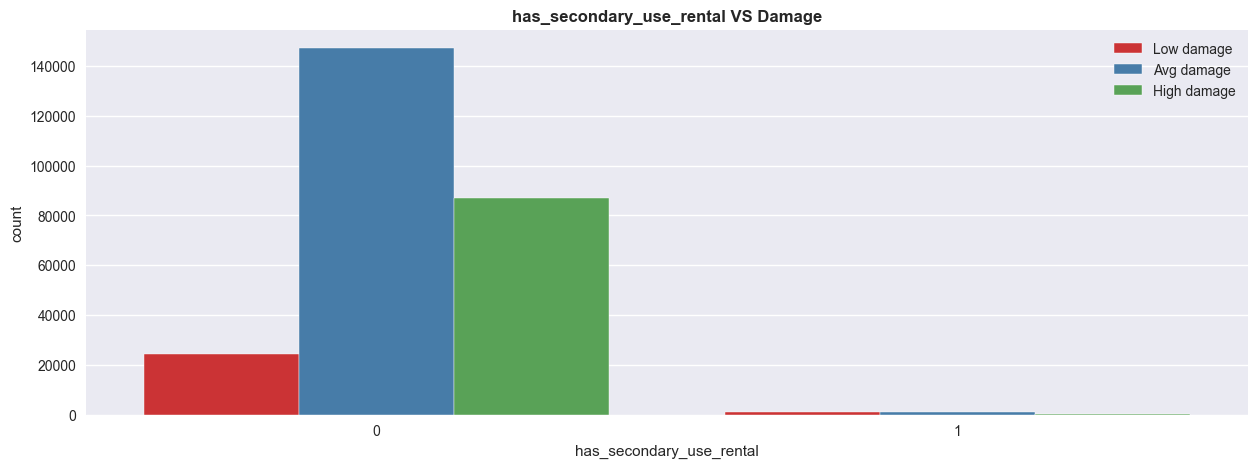

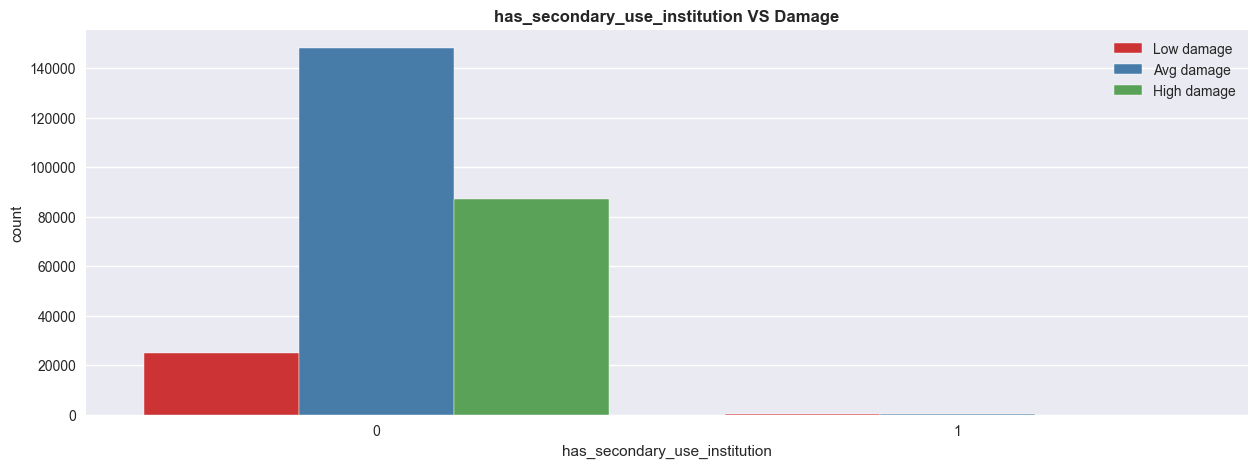

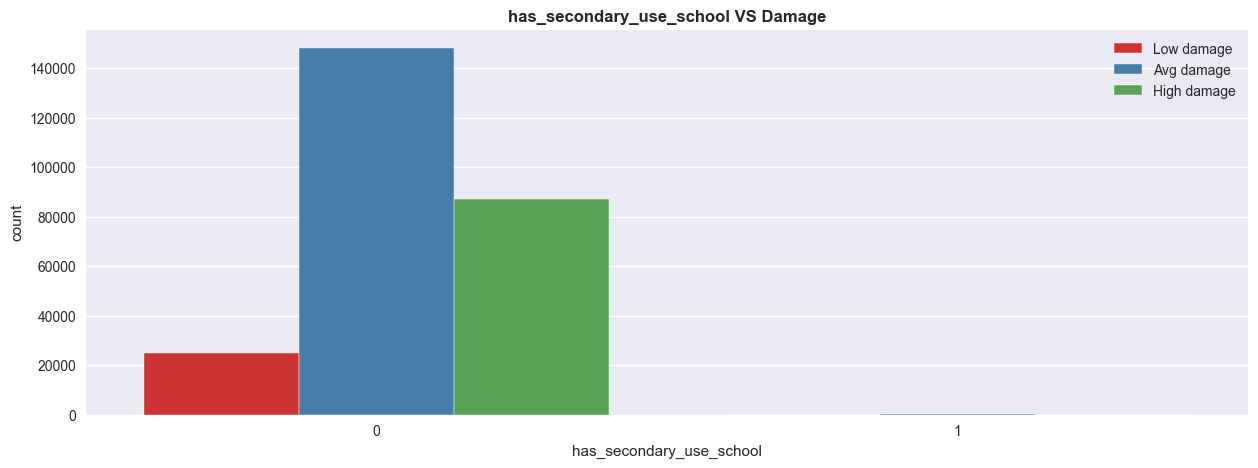

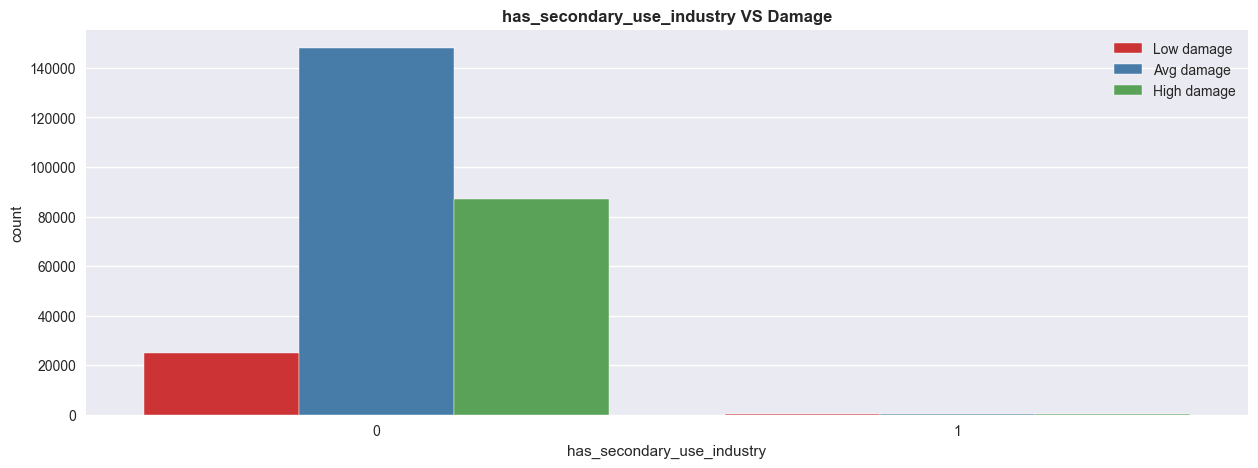

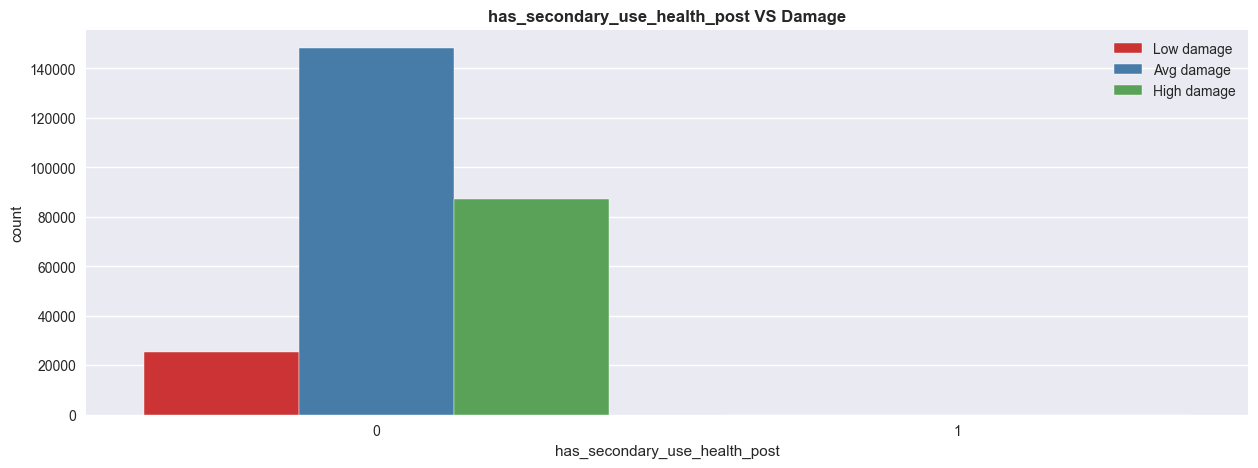

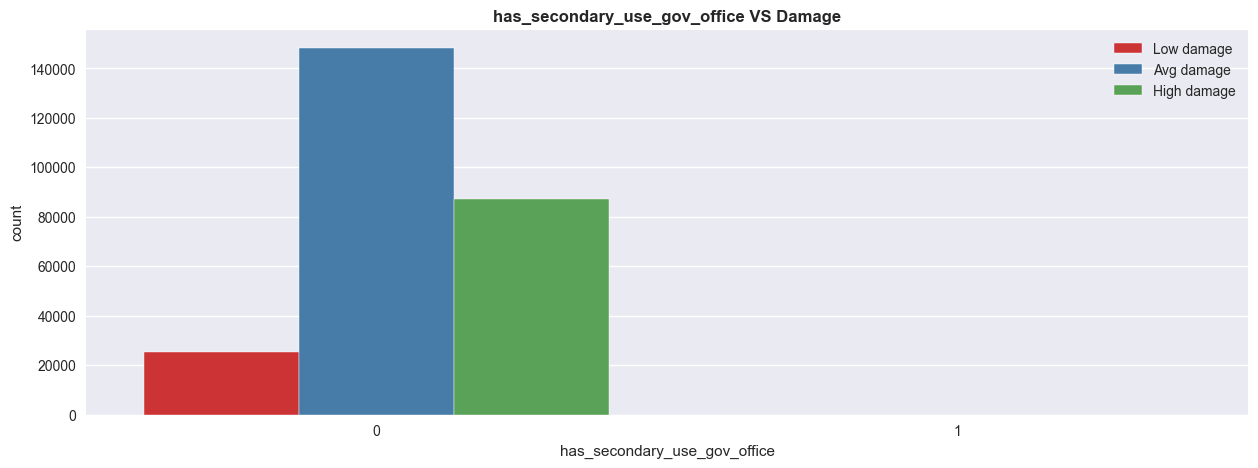

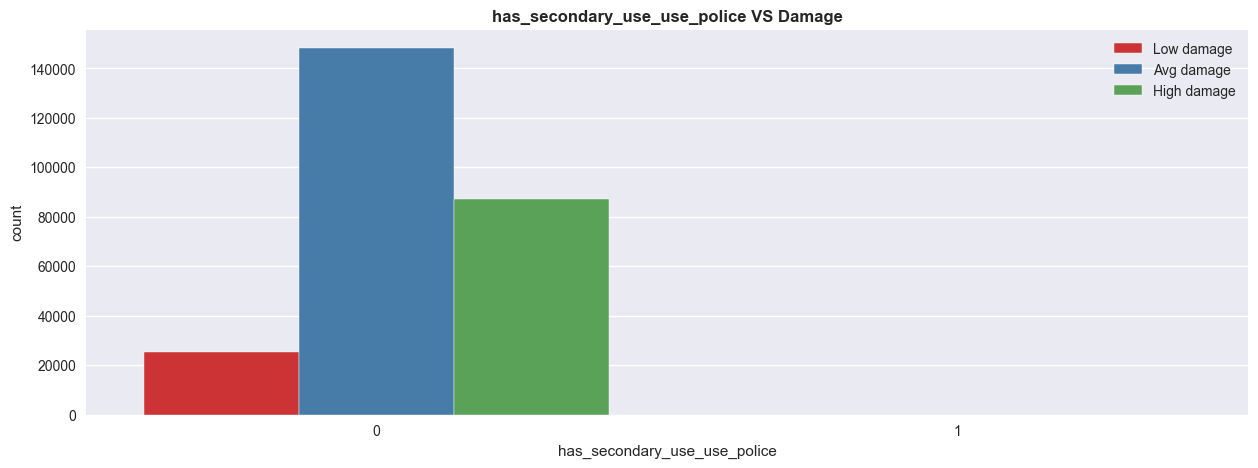

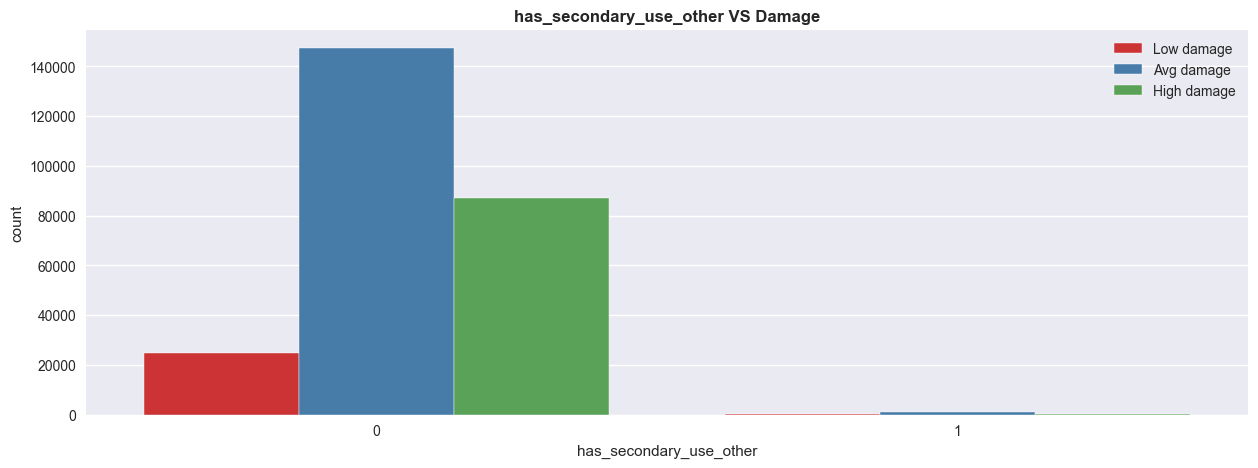

In [96]:
#check the if some correlation between binary columns will effect our model
binary_cols=["has_secondary_use_agriculture",
          "has_secondary_use_hotel","has_secondary_use_rental","has_secondary_use_institution","has_secondary_use_school","has_secondary_use_industry",
          "has_secondary_use_health_post","has_secondary_use_gov_office","has_secondary_use_use_police","has_secondary_use_other"]

for columns in binary_cols:
    plt.figure(figsize=(15,5))
    sns.countplot(x=df[columns],hue=df.damage_grade,palette="Set1")
    plt.title(columns+ " VS Damage",fontweight="bold")
    plt.legend(["Low damage","Avg damage","High damage"]) 
    plt.show()

## Observations
##### there is no effect of binary columns into damage grade so its better to remove them into our model building

In [104]:
useless_cols=[
    'has_secondary_use_gov_office','has_secondary_use_school',
    'has_secondary_use_use_police','has_secondary_use_health_post',
    'has_secondary_use_industry','has_secondary_use_institution',
    'has_secondary_use_rental','has_secondary_use_other','building_id',
    'has_secondary_use_hotel','has_secondary_use_agriculture',
    'has_superstructure_other','legal_ownership_status',
    'has_secondary_use','count_families','land_surface_condition',
    'plan_configuration','has_superstructure_timber','has_superstructure_stone_flag',
    'has_superstructure_mud_mortar_brick','has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered','has_superstructure_adobe_mud',
    'has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered'
]
df.drop(columns=useless_cols,inplace=True)

In [16]:
# #droping columns
# drop_cols=binary_cols
# other_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id']
# #drop_cols.append('building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id')
# drop_cols=other_cols
# df.drop(columns=drop_cols, inplace=True)

## Split

In [105]:
target='damage_grade'
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (260601, 14)
y shape: (260601,)


In [106]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=True)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (208480, 14)
y_train shape: (208480,)
X_val shape: (52121, 14)
y_val shape: (52121,)


## Build Model

#### Baseline Model

In [32]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.57


## Iterate
#### Logistic Regression Model

In [78]:
# Build model
model = make_pipeline(OneHotEncoder(use_cat_names=True),LogisticRegression(max_iter=1000))
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [79]:
lr_train_acc = model.score(X_train,y_train)
lr_val_acc = model.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.569037797390637
Logistic Regression, Validation Accuracy Score: 0.5705761593215787


###  DecisionTree Classifier Model

In [80]:
depth_hyperparams = range(1, 30)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    
    model_dt = make_pipeline(OneHotEncoder(use_cat_names=True),DecisionTreeClassifier(max_depth=d,random_state=42))
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train,y_train))
    validation_acc.append(model_dt.score(X_val,y_val))
 
    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.5683278971603991]
Validation Accuracy Scores: [0.5712476736823929]
Training Accuracy Scores: [0.5683278971603991, 0.5747505755947813]
Validation Accuracy Scores: [0.5712476736823929, 0.5772145584313425]
Training Accuracy Scores: [0.5683278971603991, 0.5747505755947813, 0.5747505755947813]
Validation Accuracy Scores: [0.5712476736823929, 0.5772145584313425, 0.5772145584313425]
Training Accuracy Scores: [0.5683278971603991, 0.5747505755947813, 0.5747505755947813]
Validation Accuracy Scores: [0.5712476736823929, 0.5772145584313425, 0.5772145584313425]
Training Accuracy Scores: [0.5683278971603991, 0.5747505755947813, 0.5747505755947813]
Validation Accuracy Scores: [0.5712476736823929, 0.5772145584313425, 0.5772145584313425]
Training Accuracy Scores: [0.5683278971603991, 0.5747505755947813, 0.5747505755947813]
Validation Accuracy Scores: [0.5712476736823929, 0.5772145584313425, 0.5772145584313425]
Training Accuracy Scores: [0.5683278971603991, 0.574750575594781

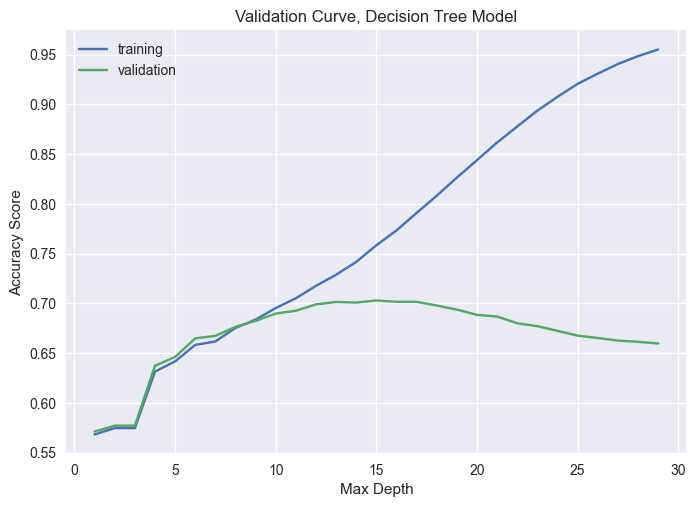

In [81]:
plt.plot(depth_hyperparams,training_acc,label='training')
plt.plot(depth_hyperparams,validation_acc , label ='validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Validation Curve, Decision Tree Model')
plt.legend()

In [107]:
final_model_dt =make_pipeline(OrdinalEncoder(),DecisionTreeClassifier(max_depth=14,random_state=42))
final_model_dt.fit(X_train,y_train)
acc_train = accuracy_score(y_train,final_model_dt.predict(X_train))
acc_val = final_model_dt.score(X_val,y_val)
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.74
Validation Accuracy: 0.7


In [108]:
features=X_train.columns
importances=final_model_dt.named_steps['decisiontreeclassifier'].feature_importances_

In [109]:
feat_imp=pd.Series(importances,index=features).sort_values()
feat_imp

count_floors_pre_eq                       0.008560
position                                  0.011217
has_superstructure_cement_mortar_brick    0.011934
ground_floor_type                         0.012217
other_floor_type                          0.018407
roof_type                                 0.019451
height_percentage                         0.027594
has_superstructure_mud_mortar_stone       0.036995
area_percentage                           0.045768
age                                       0.046856
geo_level_3_id                            0.080990
foundation_type                           0.119394
geo_level_2_id                            0.181675
geo_level_1_id                            0.378942
dtype: float64

### Removing useless columns 

In [ ]:
useless_cols=[
    'has_secondary_use_gov_office','has_secondary_use_school',
    'has_secondary_use_use_police','has_secondary_use_health_post',
    'has_secondary_use_industry','has_secondary_use_institution',
    'has_secondary_use_rental','has_secondary_use_other',
    'has_secondary_use_hotel','has_secondary_use_agriculture',
    'has_superstructure_other','legal_ownership_status',
    'has_secondary_use','building_id','count_families','land_surface_condition'
]


Text(0.5, 1.0, 'Nepal Decision Tree Feature Importance')

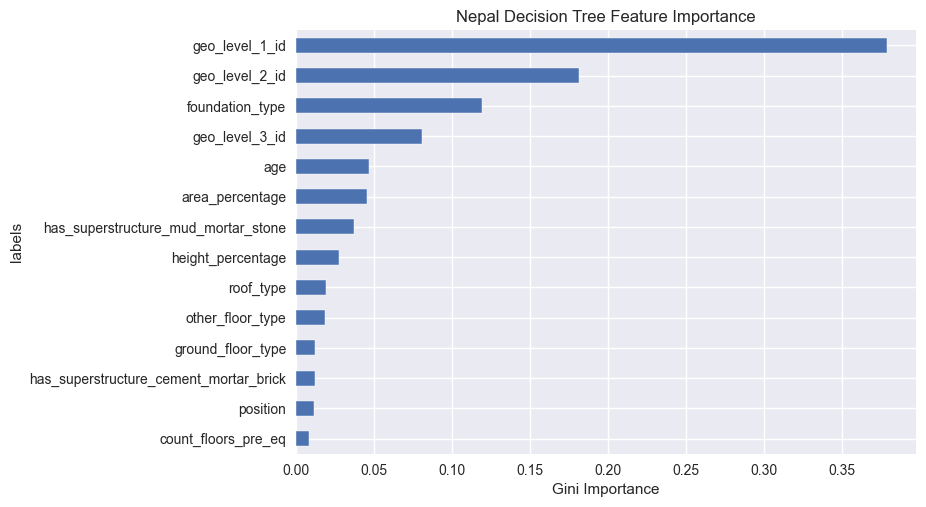

In [86]:
feat_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('labels')
plt.title('Nepal Decision Tree Feature Importance')

In [87]:
print("Accuracy Score for Random Forest :",accuracy_score(y_val,final_model_dt.predict(X_val)))
print("-"*100)
print("\n")
print("classification report for Random Forest :\n\n",classification_report(y_val, final_model_dt.predict(X_val)))

Accuracy Score for Random Forest : 0.7003127338308935
----------------------------------------------------------------------------------------------------


classification report for Random Forest :

               precision    recall  f1-score   support

           1       0.60      0.42      0.50      4998
           2       0.71      0.83      0.76     29774
           3       0.71      0.56      0.63     17349

    accuracy                           0.70     52121
   macro avg       0.67      0.60      0.63     52121
weighted avg       0.70      0.70      0.69     52121



In [112]:
X_test = pd.read_csv("test_values.csv", index_col="building_id")
useless_cols=[
    'has_secondary_use_gov_office','has_secondary_use_school',
    'has_secondary_use_use_police','has_secondary_use_health_post',
    'has_secondary_use_industry','has_secondary_use_institution',
    'has_secondary_use_rental','has_secondary_use_other',
    'has_secondary_use_hotel','has_secondary_use_agriculture',
    'has_superstructure_other','legal_ownership_status',
    'has_secondary_use','count_families','land_surface_condition',
    'plan_configuration','has_superstructure_timber','has_superstructure_stone_flag',
    'has_superstructure_mud_mortar_brick','has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered','has_superstructure_adobe_mud',
    'has_superstructure_cement_mortar_stone','has_superstructure_rc_engineered'
]
X_test.drop(columns=useless_cols,inplace=True)
y_test_pred = final_model_dt.predict(X_test)
y_test_pred

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)